In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import math
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score, roc_auc_score
from sklearn import metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

df = pd.read_csv('merged_data.csv')
df.head()

,DATE,Total Power (max),Total Power (min),Total Power (avg),Total Power (samp),HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyPrecipitation,HourlyRelativeHumidity,HourlySkyConditions,...,FG,FZ,GS,HZ,MI,PL,RA,SN,TS,VCTS
0,3/1/2019 0:00,0.0,0.0,0.0,0.0,9,17,0,70,OVC,...,0,0,0,0,0,0,0,0,0,0
1,3/1/2019 1:00,0.0,0.0,0.0,0.0,9,17,0,70,OVC,...,0,0,0,0,0,0,0,0,0,0
2,3/1/2019 2:00,0.0,0.0,0.0,0.0,9,17,0,70,OVC,...,0,0,0,0,0,0,0,0,0,0
3,3/1/2019 3:00,0.0,0.0,0.0,0.0,10,19,0,68,OVC,...,0,0,0,0,0,0,0,0,0,0
4,3/1/2019 4:00,0.0,0.0,0.0,0.0,8,16,0,71,SCT,...,0,0,0,0,0,0,0,0,0,0


In [2]:
filtered_cols = [
    'DATE',
    'Total Power (max)',
    'Total Power (avg)',
    'HourlyDryBulbTemperature',
    'HourlyWetBulbTemperature',
    'HourlyRelativeHumidity'
]
hourly = df[filtered_cols]
hourly['DATE'] = hourly['DATE'].astype(str)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [3]:
dates = []
for i, row in hourly.iterrows():
    dates.append(datetime.strptime(row['DATE'], '%m/%d/%Y %H:%M').date())
    
    for column in hourly.columns[1:]:
        try:
            hourly.at[i, column] = hourly.at[i, column].astype(float)
        except:
            hourly.at[i, column] = 0
            
daily = hourly.drop(columns = ['DATE']).copy()
daily['date'] = dates

colList = daily.copy().columns[:-1] 

In [4]:
groupby = daily.groupby('date').describe()
groupby.head()

Total Power (max)                                     \
                       count mean  std  min  25%  50%  75%  max   
date                                                              
2019-03-01              24.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2019-03-02              24.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2019-03-03              24.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2019-03-04              24.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2019-03-05              24.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

           Total Power (avg)       ... HourlyWetBulbTemperature        \
                       count mean  ...                      75%   max   
date                               ...                                  
2019-03-01              24.0  0.0  ...                    28.00  31.0   
2019-03-02              24.0  0.0  ...                    31.00  32.0   
2019-03-03              24.0  0.0  ...                    26.00  27.0   
2019-03-04              24.0  0.0  ...                    18.25  23.0   
2019-03-05              24.0  0.0  ...                    14.00  15.0   

           HourlyRelativeHumidity                                           \
                            count       mean        std   min    25%   50%   
date                                                                         
2019-03-01                   24.0  66.625000  10.503881  44.0  60.25  70.0   
2019-03-02                   24.0  79.041667   6.772574  64.0  75.00  82.0   
2019-03-03                   24.0  70.666667  11.675566  51.0  59.50  75.0   
2019-03-04                   24.0  64.291667  11.547554  50.0  54.75  61.5   
2019-03-05                   24.0  61.916667   9.249755  47.0  53.50  63.5   

                         
              75%   max  
date                     
2019-03-01  75.00  81.0  
2019-03-02  85.00  85.0  
2019-03-03  78.75  85.0  
2019-03-04  71.75  84.0  
2019-03-05  70.00  74.0  

[5 rows x 40 columns]

In [5]:
def getWeekdays(df, datecol):
    weekdays = []
    for i, row in df.iterrows():
        weekdays.append(row[datecol].weekday())

    df['weekday'] = weekdays

In [6]:
def runModel(df, model, predictorVar = 'Total Power (max)', 
             dropCols = ['date', 'Total Power (max)']):
    X = df.drop(columns = dropCols)
    Y = df[predictorVar]

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=12345)

    #print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

    #rf = RandomForestRegressor()
    model.fit(X_train, Y_train)
    
    rsq = model.score(X_test, Y_test)
    rmse = math.sqrt(metrics.mean_squared_error(Y_test, model.predict(X_test)))
    mae = metrics.mean_absolute_error(Y_test, model.predict(X_test))
    
    print("R Squared Score: {:.4f}".format(rsq))
    print("Root Mean Squared Error: {:.2f}".format(rmse))
    print("Mean Absolute Error: {:.2f}".format(mae))

    #importance = pd.DataFrame({'col_name': rf.feature_importances_}, index=X.columns).sort_values(by='col_name', ascending=False)
    #importance['col_name'] = 100*importance['col_name']
    #print(importance[:10])
    
    return mae, rmse, rsq

In [7]:
def resetDaily(groupbyDF = groupby, collist = colList, ndays = 0, trainDays = 5, 
               model = RandomForestRegressor()):
    parameters = ['min', 'max', 'mean']
    dailyCols = ['date']
    dailyData = {'date':list(groupby.index)}

    for column in collist:
        if(column == 'Total Power (max)'):
            dailyData['Total Power (max)'] = list(groupby[column]['max'])
        elif(column == 'Total Power (avg)'):
            dailyData['Total Power (avg)'] = list(groupby[column]['mean'])
        else:                                     
            for param in parameters:
                dailyData[param + "_" + column] = list(groupby[column][param])

    daily = pd.DataFrame(dailyData)
    
    nday_cols = [
        'mean_HourlyDryBulbTemperature',
        'mean_HourlyWetBulbTemperature',
        'max_HourlyDryBulbTemperature',
        'max_HourlyWetBulbTemperature',
        'Total Power (avg)', 'Total Power (max)'
    ]
    
    if(ndays > 0):
        for col in nday_cols[:-2]:
            for i in range(ndays + trainDays):
                colname = col + "-" + str(i + 1) + "day"
                daily[colname] = daily[col].shift(i+1)
        
        for col in nday_cols[-2:]:
            for i in range(ndays, trainDays + ndays):
                colname = col + "-" + str(i) + "day"
                daily[colname] = daily[col].shift(i)
        
    daily = daily.dropna().drop(columns = ['Total Power (avg)'])
    
    getWeekdays(daily, 'date')
    
    mae, rmse, rsq = runModel(daily, model)

    return daily, mae, rmse, rsq

In [8]:
def pltErrors(trainingDays,
             errorDict = {'ndays':[],'MAE':[], 'RMSE':[], 'RSQ':[]}):
    plt.plot(errorDict['ndays'], errorDict['MAE'])
    plt.plot(errorDict['ndays'], errorDict['RMSE'])

    plt.legend(['MAE', 'RMSE'])
    plt.xlabel('n_days')
    plt.ylabel('Model Error')
    plt.title('Train Days = ' + str(trainingDays+1))
    plt.ylim(ymin=0, ymax =3000)
    xint = range(min(errorDict['ndays']), math.ceil(max(errorDict['ndays']))+1)
    plt.xticks(xint)
    
    plt.show()

In [9]:
resetDaily(ndays = 5, trainDays = 10)[0].columns

R Squared Score: 0.9201
Root Mean Squared Error: 1983.02
Mean Absolute Error: 990.11


Index(['date', 'Total Power (max)', 'min_HourlyDryBulbTemperature',
       'max_HourlyDryBulbTemperature', 'mean_HourlyDryBulbTemperature',
       'min_HourlyWetBulbTemperature', 'max_HourlyWetBulbTemperature',
       'mean_HourlyWetBulbTemperature', 'min_HourlyRelativeHumidity',
       'max_HourlyRelativeHumidity', 'mean_HourlyRelativeHumidity',
       'mean_HourlyDryBulbTemperature-1day',
       'mean_HourlyDryBulbTemperature-2day',
       'mean_HourlyDryBulbTemperature-3day',
       'mean_HourlyDryBulbTemperature-4day',
       'mean_HourlyDryBulbTemperature-5day',
       'mean_HourlyDryBulbTemperature-6day',
       'mean_HourlyDryBulbTemperature-7day',
       'mean_HourlyDryBulbTemperature-8day',
       'mean_HourlyDryBulbTemperature-9day',
       'mean_HourlyDryBulbTemperature-10day',
       'mean_HourlyDryBulbTemperature-11day',
       'mean_HourlyDryBulbTemperature-12day',
       'mean_HourlyDryBulbTemperature-13day',
       'mean_HourlyDryBulbTemperature-14day',
       'mean_Hou

In [10]:
def testErrors(model = RandomForestRegressor(), 
               trainDaysRange = 10, n_days= 5):
    for j in range(trainDaysRange):
        errors = {'ndays':[],'MAE':[], 'RMSE':[], 'RSQ':[]}
        for i in range(n_days):
            print("{} days:".format(i+1))
            daily, mae, rmse, rsq = resetDaily(model, 
                                               ndays = i+1, trainDays = j+1)
            print()

            errors['MAE'].append(mae)
            errors['RMSE'].append(rmse)
            errors['RSQ'].append(rsq)
            errors['ndays'].append(i+1)

        pltErrors(j, errors)

1 days:
R Squared Score: 0.9712
Root Mean Squared Error: 1141.40
Mean Absolute Error: 677.54

2 days:
R Squared Score: 0.9523
Root Mean Squared Error: 1459.60
Mean Absolute Error: 793.14

3 days:
R Squared Score: 0.9497
Root Mean Squared Error: 1516.88
Mean Absolute Error: 915.51

4 days:
R Squared Score: 0.9503
Root Mean Squared Error: 1511.72
Mean Absolute Error: 1014.33

5 days:
R Squared Score: 0.9022
Root Mean Squared Error: 2208.02
Mean Absolute Error: 1080.62



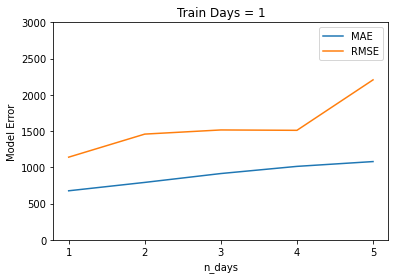

1 days:
R Squared Score: 0.9679
Root Mean Squared Error: 1198.32
Mean Absolute Error: 681.36

2 days:
R Squared Score: 0.9616
Root Mean Squared Error: 1324.59
Mean Absolute Error: 850.60

3 days:
R Squared Score: 0.9536
Root Mean Squared Error: 1460.88
Mean Absolute Error: 981.77

4 days:
R Squared Score: 0.9021
Root Mean Squared Error: 2208.16
Mean Absolute Error: 1041.39

5 days:
R Squared Score: 0.9273
Root Mean Squared Error: 1824.29
Mean Absolute Error: 1014.59



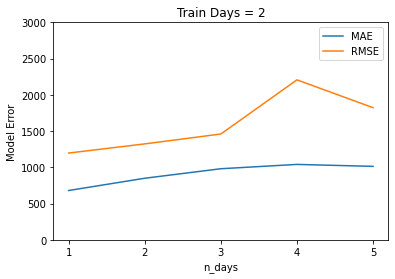

1 days:
R Squared Score: 0.9740
Root Mean Squared Error: 1091.07
Mean Absolute Error: 718.86

2 days:
R Squared Score: 0.9546
Root Mean Squared Error: 1444.63
Mean Absolute Error: 922.00

3 days:
R Squared Score: 0.9059
Root Mean Squared Error: 2165.83
Mean Absolute Error: 986.56

4 days:
R Squared Score: 0.9293
Root Mean Squared Error: 1798.58
Mean Absolute Error: 1002.23

5 days:
R Squared Score: 0.9664
Root Mean Squared Error: 1250.41
Mean Absolute Error: 827.89



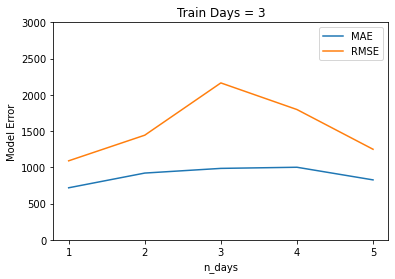

1 days:
R Squared Score: 0.9677
Root Mean Squared Error: 1218.85
Mean Absolute Error: 774.69

2 days:
R Squared Score: 0.9163
Root Mean Squared Error: 2041.67
Mean Absolute Error: 930.13

3 days:
R Squared Score: 0.9313
Root Mean Squared Error: 1773.06
Mean Absolute Error: 943.72

4 days:
R Squared Score: 0.9664
Root Mean Squared Error: 1251.04
Mean Absolute Error: 823.46

5 days:
R Squared Score: 0.9358
Root Mean Squared Error: 1696.58
Mean Absolute Error: 1023.37



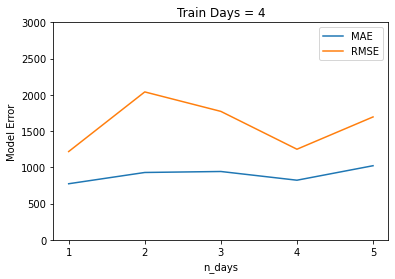

1 days:
R Squared Score: 0.9130
Root Mean Squared Error: 2081.86
Mean Absolute Error: 902.95

2 days:
R Squared Score: 0.9333
Root Mean Squared Error: 1747.39
Mean Absolute Error: 914.23

3 days:
R Squared Score: 0.9679
Root Mean Squared Error: 1222.78
Mean Absolute Error: 788.30

4 days:
R Squared Score: 0.9406
Root Mean Squared Error: 1631.52
Mean Absolute Error: 980.02

5 days:
R Squared Score: 0.9329
Root Mean Squared Error: 1705.54
Mean Absolute Error: 996.30



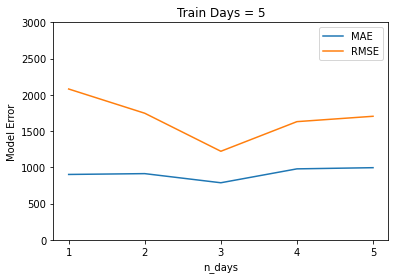

1 days:
R Squared Score: 0.9533
Root Mean Squared Error: 1462.10
Mean Absolute Error: 817.18

2 days:
R Squared Score: 0.9720
Root Mean Squared Error: 1141.19
Mean Absolute Error: 738.40

3 days:
R Squared Score: 0.9379
Root Mean Squared Error: 1668.24
Mean Absolute Error: 951.35

4 days:
R Squared Score: 0.9278
Root Mean Squared Error: 1769.17
Mean Absolute Error: 1025.86

5 days:
R Squared Score: 0.9252
Root Mean Squared Error: 1882.18
Mean Absolute Error: 1033.08



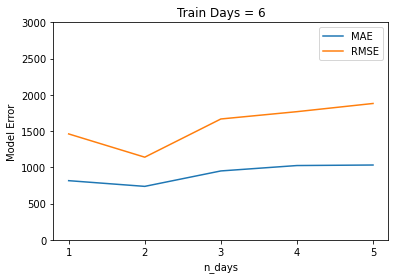

1 days:
R Squared Score: 0.9767
Root Mean Squared Error: 1040.92
Mean Absolute Error: 693.30

2 days:
R Squared Score: 0.9466
Root Mean Squared Error: 1547.11
Mean Absolute Error: 892.35

3 days:
R Squared Score: 0.9258
Root Mean Squared Error: 1794.23
Mean Absolute Error: 997.89

4 days:
R Squared Score: 0.9232
Root Mean Squared Error: 1907.02
Mean Absolute Error: 1042.45

5 days:
R Squared Score: 0.8467
Root Mean Squared Error: 2724.97
Mean Absolute Error: 1208.75



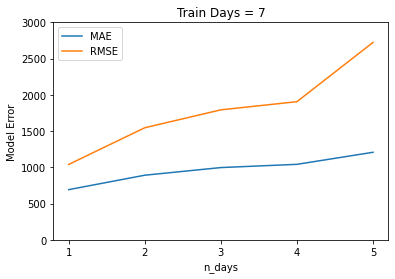

1 days:
R Squared Score: 0.9615
Root Mean Squared Error: 1314.22
Mean Absolute Error: 762.76

2 days:
R Squared Score: 0.9438
Root Mean Squared Error: 1561.85
Mean Absolute Error: 885.62

3 days:
R Squared Score: 0.9265
Root Mean Squared Error: 1866.22
Mean Absolute Error: 984.94

4 days:
R Squared Score: 0.8482
Root Mean Squared Error: 2711.15
Mean Absolute Error: 1205.00

5 days:
R Squared Score: 0.8877
Root Mean Squared Error: 2267.42
Mean Absolute Error: 1186.88



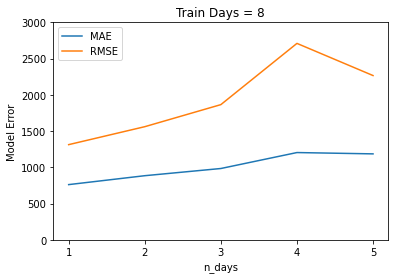

1 days:
R Squared Score: 0.9608
Root Mean Squared Error: 1304.50
Mean Absolute Error: 781.06

2 days:
R Squared Score: 0.9429
Root Mean Squared Error: 1644.52
Mean Absolute Error: 910.44

3 days:
R Squared Score: 0.8490
Root Mean Squared Error: 2704.70
Mean Absolute Error: 1191.78

4 days:
R Squared Score: 0.8888
Root Mean Squared Error: 2256.08
Mean Absolute Error: 1167.89

5 days:
R Squared Score: 0.8659
Root Mean Squared Error: 2488.78
Mean Absolute Error: 1260.91



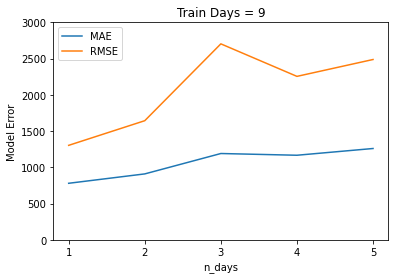

1 days:
R Squared Score: 0.9592
Root Mean Squared Error: 1390.22
Mean Absolute Error: 824.52

2 days:
R Squared Score: 0.8611
Root Mean Squared Error: 2593.80
Mean Absolute Error: 1138.50

3 days:
R Squared Score: 0.8894
Root Mean Squared Error: 2250.42
Mean Absolute Error: 1092.66

4 days:
R Squared Score: 0.8645
Root Mean Squared Error: 2501.85
Mean Absolute Error: 1223.92

5 days:
R Squared Score: 0.9170
Root Mean Squared Error: 2021.41
Mean Absolute Error: 1037.85



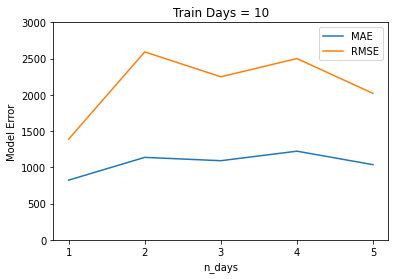

In [11]:
testErrors(model = RandomForestRegressor())

1 days:
R Squared Score: 0.9713
Root Mean Squared Error: 1139.45
Mean Absolute Error: 695.61

2 days:
R Squared Score: 0.9507
Root Mean Squared Error: 1484.19
Mean Absolute Error: 806.53

3 days:
R Squared Score: 0.9469
Root Mean Squared Error: 1558.41
Mean Absolute Error: 927.40

4 days:
R Squared Score: 0.9494
Root Mean Squared Error: 1525.40
Mean Absolute Error: 1028.70

5 days:
R Squared Score: 0.9009
Root Mean Squared Error: 2222.03
Mean Absolute Error: 1079.94



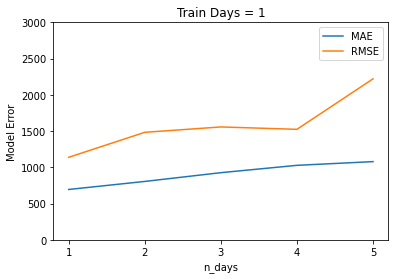

1 days:
R Squared Score: 0.9678
Root Mean Squared Error: 1200.55
Mean Absolute Error: 699.30

2 days:
R Squared Score: 0.9670
Root Mean Squared Error: 1228.18
Mean Absolute Error: 816.54

3 days:
R Squared Score: 0.9526
Root Mean Squared Error: 1477.15
Mean Absolute Error: 980.11

4 days:
R Squared Score: 0.9055
Root Mean Squared Error: 2169.84
Mean Absolute Error: 1042.51

5 days:
R Squared Score: 0.9314
Root Mean Squared Error: 1772.41
Mean Absolute Error: 970.56



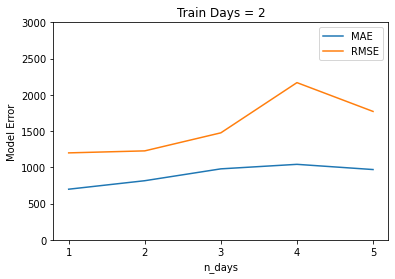

1 days:
R Squared Score: 0.9755
Root Mean Squared Error: 1059.72
Mean Absolute Error: 703.11

2 days:
R Squared Score: 0.9553
Root Mean Squared Error: 1433.21
Mean Absolute Error: 912.39

3 days:
R Squared Score: 0.9045
Root Mean Squared Error: 2180.79
Mean Absolute Error: 1000.05

4 days:
R Squared Score: 0.9288
Root Mean Squared Error: 1805.93
Mean Absolute Error: 988.34

5 days:
R Squared Score: 0.9664
Root Mean Squared Error: 1250.78
Mean Absolute Error: 809.45



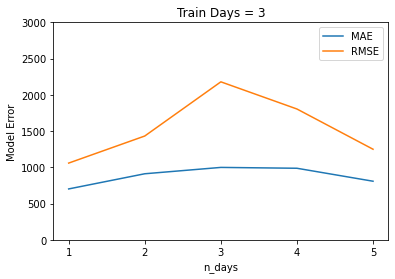

1 days:
R Squared Score: 0.9686
Root Mean Squared Error: 1202.16
Mean Absolute Error: 771.27

2 days:
R Squared Score: 0.9157
Root Mean Squared Error: 2048.88
Mean Absolute Error: 929.93

3 days:
R Squared Score: 0.9311
Root Mean Squared Error: 1775.81
Mean Absolute Error: 940.36

4 days:
R Squared Score: 0.9691
Root Mean Squared Error: 1198.50
Mean Absolute Error: 786.60

5 days:
R Squared Score: 0.9337
Root Mean Squared Error: 1724.25
Mean Absolute Error: 1022.56



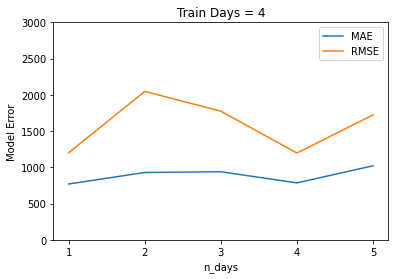

1 days:
R Squared Score: 0.9177
Root Mean Squared Error: 2024.94
Mean Absolute Error: 877.44

2 days:
R Squared Score: 0.9337
Root Mean Squared Error: 1742.10
Mean Absolute Error: 912.82

3 days:
R Squared Score: 0.9701
Root Mean Squared Error: 1180.07
Mean Absolute Error: 757.33

4 days:
R Squared Score: 0.9353
Root Mean Squared Error: 1703.24
Mean Absolute Error: 1010.48

5 days:
R Squared Score: 0.9262
Root Mean Squared Error: 1788.87
Mean Absolute Error: 1031.58



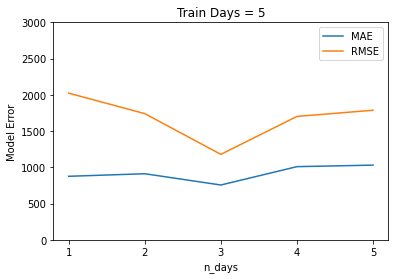

1 days:
R Squared Score: 0.9515
Root Mean Squared Error: 1490.10
Mean Absolute Error: 784.04

2 days:
R Squared Score: 0.9706
Root Mean Squared Error: 1168.87
Mean Absolute Error: 756.88

3 days:
R Squared Score: 0.9368
Root Mean Squared Error: 1682.52
Mean Absolute Error: 943.35

4 days:
R Squared Score: 0.9276
Root Mean Squared Error: 1772.43
Mean Absolute Error: 994.64

5 days:
R Squared Score: 0.9291
Root Mean Squared Error: 1832.52
Mean Absolute Error: 1021.18



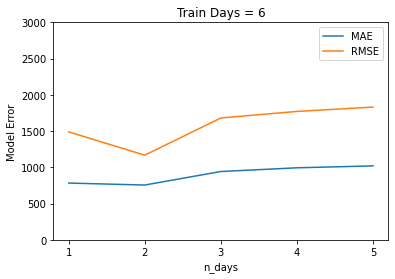

1 days:
R Squared Score: 0.9762
Root Mean Squared Error: 1051.86
Mean Absolute Error: 692.52

2 days:
R Squared Score: 0.9542
Root Mean Squared Error: 1432.22
Mean Absolute Error: 869.95

3 days:
R Squared Score: 0.9310
Root Mean Squared Error: 1729.82
Mean Absolute Error: 981.59

4 days:
R Squared Score: 0.9287
Root Mean Squared Error: 1837.14
Mean Absolute Error: 989.50

5 days:
R Squared Score: 0.8477
Root Mean Squared Error: 2715.66
Mean Absolute Error: 1218.91



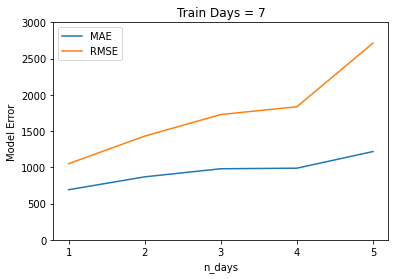

1 days:
R Squared Score: 0.9672
Root Mean Squared Error: 1211.93
Mean Absolute Error: 748.80

2 days:
R Squared Score: 0.9411
Root Mean Squared Error: 1598.34
Mean Absolute Error: 921.13

3 days:
R Squared Score: 0.9305
Root Mean Squared Error: 1814.71
Mean Absolute Error: 966.00

4 days:
R Squared Score: 0.8488
Root Mean Squared Error: 2706.16
Mean Absolute Error: 1189.85

5 days:
R Squared Score: 0.8880
Root Mean Squared Error: 2264.52
Mean Absolute Error: 1176.97



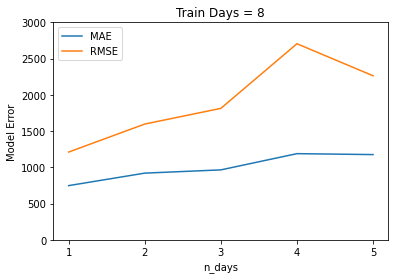

1 days:
R Squared Score: 0.9607
Root Mean Squared Error: 1305.94
Mean Absolute Error: 780.93

2 days:
R Squared Score: 0.9463
Root Mean Squared Error: 1594.84
Mean Absolute Error: 877.80

3 days:
R Squared Score: 0.8514
Root Mean Squared Error: 2682.88
Mean Absolute Error: 1182.65

4 days:
R Squared Score: 0.8844
Root Mean Squared Error: 2299.78
Mean Absolute Error: 1198.05

5 days:
R Squared Score: 0.8673
Root Mean Squared Error: 2475.83
Mean Absolute Error: 1258.93



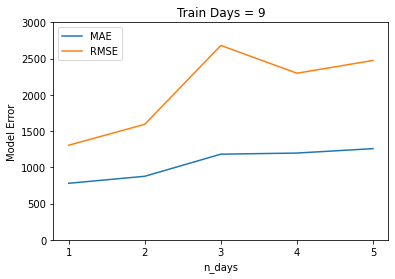

1 days:
R Squared Score: 0.9588
Root Mean Squared Error: 1396.30
Mean Absolute Error: 825.63

2 days:
R Squared Score: 0.8653
Root Mean Squared Error: 2554.19
Mean Absolute Error: 1099.92

3 days:
R Squared Score: 0.8910
Root Mean Squared Error: 2233.72
Mean Absolute Error: 1117.61

4 days:
R Squared Score: 0.8677
Root Mean Squared Error: 2472.55
Mean Absolute Error: 1217.28

5 days:
R Squared Score: 0.9208
Root Mean Squared Error: 1974.79
Mean Absolute Error: 1002.68



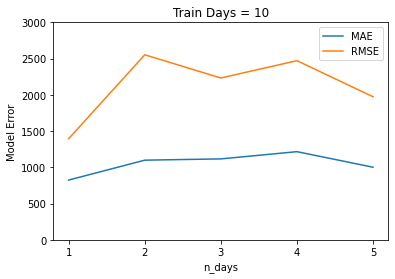

In [12]:
testErrors(model = GradientBoostingRegressor())